<h1>Elecciones 2019</h1>

<h2>Configuracion</h2>

<b>Instalations</b>

In [1]:
%pip install --upgrade plotly
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


<b>Imports</b>

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

<b>Pandas Config</b>

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

<h2>Base de datos general</h2>

<b>Importar archivo</b>

In [4]:
file_name = "ResultadosElectorales_2019.csv"
df_data = pd.read_csv(file_name, low_memory=False, encoding="utf-8")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423442 entries, 0 to 3423441
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Año                       int64  
 1   eleccion_tipo             object 
 2   recuento_tipo             object 
 3   padron_tipo               object 
 4   distrito_id               int64  
 5   distrito_nombre           object 
 6   seccionprovincial_id      int64  
 7   seccionprovincial_nombre  object 
 8   seccion_id                int64  
 9   seccion_nombre            object 
 10  circuito_id               object 
 11  circuito_nombre           float64
 12  mesa_id                   int64  
 13  mesa_electores            int64  
 14  mesa_tipo                 object 
 15  cargo_id                  int64  
 16  cargo_nombre              object 
 17  agrupacion_id             object 
 18  agrupacion_nombre         object 
 19  lista_numero              float64
 20  lista_nombre            

<b>Listar los cargos</b>

In [5]:
df_data["cargo_nombre"].unique()

array(['DIPUTADOS NACIONALES', 'PRESIDENTE', 'JEFE DE GOBIERNO',
       'SENADORES NACIONALES', 'GOBERNADOR', 'DIPUTADOS PROVINCIALES',
       'INTENDENTE', 'SENADORES PROVINCIALES',
       'DIPUTADOS/AS DE LA CIUDAD', 'MIEMBROS DE LA JUNTA COMUNAL'],
      dtype=object)

<b>Preparar la informacion</b>

In [5]:
cargo_presidencial = "PRESIDENTE"

# Agregar un ID combinado para asegurarase que sea unico
df_data['id_mesa_unico'] = df_data['distrito_id'].astype(str) + "-" + \
                          df_data['seccionprovincial_id'].astype(str) + "-" + \
                          df_data['seccion_id'].astype(str) + "-" + \
                          df_data['circuito_id'].astype(str) + "-" + \
                          df_data['mesa_id'].astype(str)

# Considerar solo los votos positivos
votos_positivos = df_data[df_data['votos_tipo'] == "POSITIVO"]

# Considerar solo los votos para presidente
votos_positivos_presidenciales = votos_positivos[votos_positivos["cargo_nombre"]==cargo_presidencial]

# Obtener los totales por mesa
votos_positivos_presidenciales_by_mesa = votos_positivos_presidenciales.groupby('id_mesa_unico')['votos_cantidad'].sum().reset_index()

#Agregar el total de cada mesa a cada registro
votos_positivos_presidenciales = votos_positivos_presidenciales.merge(votos_positivos_presidenciales_by_mesa, on='id_mesa_unico', how='left', suffixes=('', '_sum'))
# Renombrar la columna
votos_positivos_presidenciales = votos_positivos_presidenciales.rename(columns={'votos_cantidad_sum': 'total_votos_mesa'})

# Calcular el porcentaje
votos_positivos_presidenciales['votos_porcentaje'] = (votos_positivos_presidenciales['votos_cantidad'] / votos_positivos_presidenciales['total_votos_mesa']) * 100

# Eliminar las mesas que dan NaN en el porcentaje (tienen 0 votos)
votos_positivos_presidenciales.dropna(subset=['votos_porcentaje'], inplace=True)


<h2>Chequear TOTALES por partido con la informacion oficial</h2><br>
Para asegurarse que estamos trabjando con el 100% de la informacion

In [6]:
# Calcular totales
totales_por_partido = votos_positivos_presidenciales.groupby('agrupacion_nombre')['votos_cantidad'].sum()

# Convertir a DataFrame
df_totales = totales_por_partido.reset_index()

# Calcular el total general
overall_total = df_totales['votos_cantidad'].sum()
print(f"Total General: {overall_total:,}")

# Calcular el porcentaje por partido
df_totales['porcentaje'] = (df_totales['votos_cantidad'] / overall_total) * 100
# Agregar separadores a la cantidad de votos
df_totales['votos_cantidad'] = df_totales['votos_cantidad'].apply(lambda x: f"{x:,}")

# Display the DataFrame
df_totales

Total General: 25,931,564


,agrupacion_nombre,votos_cantidad,porcentaje
0,CONSENSO FEDERAL,"1,599,707",6.17
1,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,"561,214",2.16
2,FRENTE DE TODOS,"12,473,709",48.10
3,FRENTE NOS,"443,507",1.71
4,JUNTOS POR EL CAMBIO,"10,470,607",40.38
5,UNITE POR LA LIBERTAD Y LA DIGNIDAD,"382,820",1.48


<img src="totales_oficiales_2019.png">

<h2>Informacion por partido</h2>

<b>Totales</b><br>
Ponderado en base a la cantidad de votantes por mesa

In [7]:
fdt_total = votos_positivos_presidenciales[(votos_positivos_presidenciales['agrupacion_nombre'] == "FRENTE DE TODOS")].copy()
jxc_total = votos_positivos_presidenciales[(votos_positivos_presidenciales['agrupacion_nombre'] == "JUNTOS POR EL CAMBIO")].copy()

# Promedio de votantes por mesa (es lo mismo para todos los partidos) 
promedio_vot = fdt_total["total_votos_mesa"].mean()

# Agregar la ponderacion a la tabla de cada partido
fdt_total['ponderacion'] = fdt_total['total_votos_mesa'] / promedio_vot
jxc_total['ponderacion'] = jxc_total['total_votos_mesa'] / promedio_vot


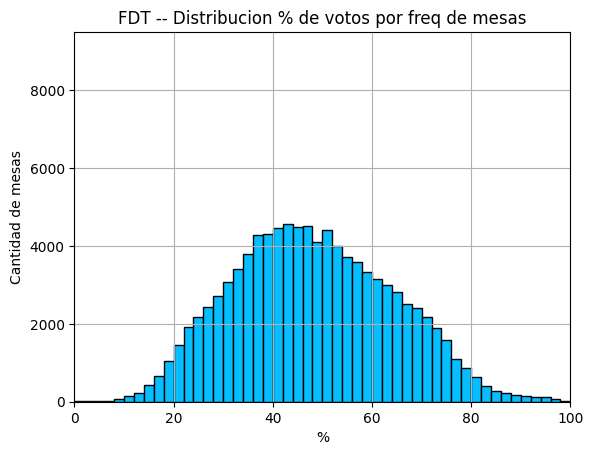

In [8]:
## FDT
# Crear Histograma
fdt_total['votos_porcentaje'].hist(bins=50, weights=fdt_total['ponderacion'], edgecolor='black', color="#06beff")

# Add title and labels
plt.title('FDT -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 9500)
plt.xlim(0, 100)

# Mostrar grafico
plt.show()

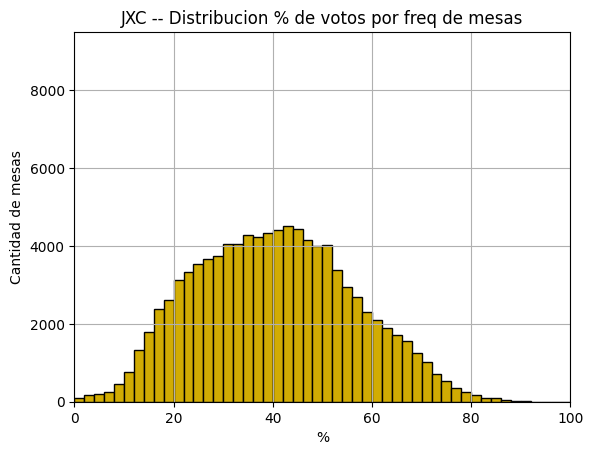

In [9]:
## JXC
# Crear Histograma
jxc_total['votos_porcentaje'].hist(bins=50, weights=jxc_total['ponderacion'], edgecolor='black', color="#d1ac03")

# Add title and labels
plt.title('JXC -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 9500)
plt.xlim(0, 100)

# Mostrar grafico
plt.show()

<b>Colas</b><br>
Filtrando mesas con 30 votos o mas, en las que los candidatos obtuvieron mas del 70%.

In [10]:
# Resultados filtrados 
fdt_cola = fdt_total[(fdt_total['votos_porcentaje'] > 70) & (fdt_total['total_votos_mesa'] > 30)]
jxc_cola = jxc_total[(jxc_total['votos_porcentaje'] > 70) & (jxc_total['total_votos_mesa'] > 30)]


FDT obtuvo 70% o mas en 10,085 mesas, por un total de 2,001,739 votos.
Esto representa el 16.05% de sus votos y el 7.72% del total de votos.



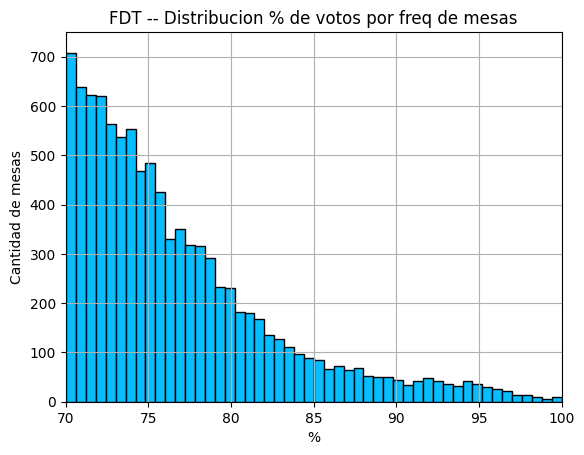

In [11]:
## FDT

# Estadisticas
fdt_cola_mesas = len(fdt_cola)
fdt_cola_votos = fdt_cola["votos_cantidad"].sum()
fdt_cola_porc_sus_votos = (fdt_cola["votos_cantidad"].sum() / fdt_total["votos_cantidad"].sum()) * 100
fdt_cola_porc_total = (fdt_cola["votos_cantidad"].sum() / overall_total) * 100
print(f"FDT obtuvo 70% o mas en {fdt_cola_mesas:,} mesas, por un total de {fdt_cola_votos:,} votos.")
print(f"Esto representa el {fdt_cola_porc_sus_votos:.2f}% de sus votos y el {fdt_cola_porc_total:.2f}% del total de votos.\n")

# Crear Histograma
fdt_cola['votos_porcentaje'].hist(bins=50, weights=fdt_cola['ponderacion'], edgecolor='black', color="#06beff")

# Add title and labels
plt.title('FDT -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 750)
plt.xlim(70, 100)

# Mostrar grafico
plt.show()

JxC obtuvo 70% o mas en 3,312 mesas, por un total de 645,073 votos.
Esto representa el 6.16% de sus votos y el 2.49% del total de votos.



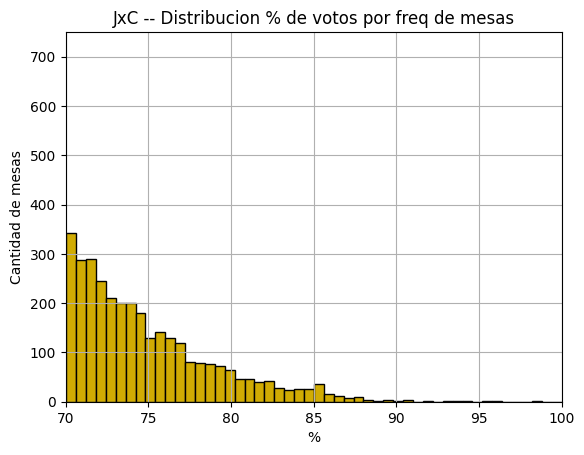

In [12]:
## JxC

# Estadisticas
jxc_cola_mesas = len(jxc_cola)
jxc_cola_votos = jxc_cola["votos_cantidad"].sum()
jxc_cola_porc_sus_votos = (jxc_cola["votos_cantidad"].sum() / jxc_total["votos_cantidad"].sum()) * 100
jxc_cola_porc_total = (jxc_cola["votos_cantidad"].sum() / overall_total) * 100
print(f"JxC obtuvo 70% o mas en {jxc_cola_mesas:,} mesas, por un total de {jxc_cola_votos:,} votos.")
print(f"Esto representa el {jxc_cola_porc_sus_votos:.2f}% de sus votos y el {jxc_cola_porc_total:.2f}% del total de votos.\n")

# Crear Histograma
jxc_cola['votos_porcentaje'].hist(bins=50, weights=jxc_cola['ponderacion'], edgecolor='black', color="#d1ac03")

# Add title and labels
plt.title('JxC -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 750)
plt.xlim(70, 100)

# Mostrar grafico
plt.show()

<b>Colas 85%</b><br>
Filtrando mesas con 30 votos o mas, en las que los candidatos obtuvieron mas del 85%, teniendo en cuenta que en este año hubo basicamente 2 opciones (en vez de 3 como en 2023).

In [13]:
# Resultados filtrados 
fdt_cola_85 = fdt_total[(fdt_total['votos_porcentaje'] > 85) & (fdt_total['total_votos_mesa'] > 30)]
jxc_cola_85 = jxc_total[(jxc_total['votos_porcentaje'] > 85) & (jxc_total['total_votos_mesa'] > 30)]

FDT obtuvo 85% o mas en 1,176 mesas, por un total de 239,460 votos.
Esto representa el 1.92% de sus votos y el 0.92% del total de votos.



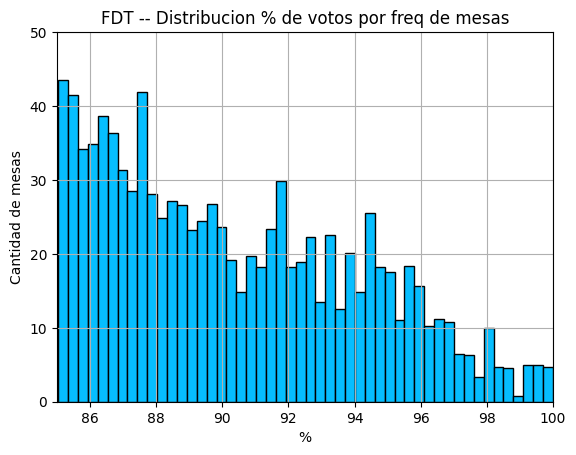

In [14]:
## FDT

# Estadisticas
fdt_cola_85_mesas = len(fdt_cola_85)
fdt_cola_85_votos = fdt_cola_85["votos_cantidad"].sum()
fdt_cola_85_porc_sus_votos = (fdt_cola_85["votos_cantidad"].sum() / fdt_total["votos_cantidad"].sum()) * 100
fdt_cola_85_porc_total = (fdt_cola_85["votos_cantidad"].sum() / overall_total) * 100
print(f"FDT obtuvo 85% o mas en {fdt_cola_85_mesas:,} mesas, por un total de {fdt_cola_85_votos:,} votos.")
print(f"Esto representa el {fdt_cola_85_porc_sus_votos:.2f}% de sus votos y el {fdt_cola_85_porc_total:.2f}% del total de votos.\n")

# Crear Histograma
fdt_cola_85['votos_porcentaje'].hist(bins=50, weights=fdt_cola_85['ponderacion'], edgecolor='black', color="#06beff")

# Add title and labels
plt.title('FDT -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 50)
plt.xlim(85, 100)

# Exportar imagen
plt.savefig('up-cola-2019.png')

# Mostrar grafico
plt.show()

JxC obtuvo 85% o mas en 122 mesas, por un total de 23,934 votos.
Esto representa el 0.23% de sus votos y el 0.09% del total de votos.



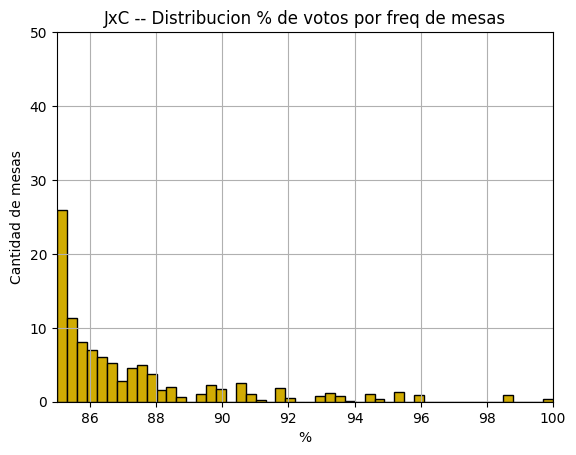

In [16]:
## JxC

# Estadisticas
jxc_cola_85_mesas = len(jxc_cola_85)
jxc_cola_85_votos = jxc_cola_85["votos_cantidad"].sum()
jxc_cola_85_porc_sus_votos = (jxc_cola_85["votos_cantidad"].sum() / jxc_total["votos_cantidad"].sum()) * 100
jxc_cola_85_porc_total = (jxc_cola_85["votos_cantidad"].sum() / overall_total) * 100
print(f"JxC obtuvo 85% o mas en {jxc_cola_85_mesas:,} mesas, por un total de {jxc_cola_85_votos:,} votos.")
print(f"Esto representa el {jxc_cola_85_porc_sus_votos:.2f}% de sus votos y el {jxc_cola_85_porc_total:.2f}% del total de votos.\n")

# Crear Histograma
jxc_cola_85['votos_porcentaje'].hist(bins=50, weights=jxc_cola_85['ponderacion'], edgecolor='black', color="#d1ac03")

# Add title and labels
plt.title('JxC -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 50)
plt.xlim(85, 100)

# Exportar imagen
plt.savefig('jxc-cola-2019.png')

# Mostrar grafico
plt.show()